# Clasificador de Flores

* Luis Gerardo Ortiz Quintana 219220371
* José Isaías Olmos Morales 219212278


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import numpy as np
import math

Obteniendo DataSet de Flores

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Descargar dataset de flores. Oxford_Flowers102.
datos, metadatos = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

BATCH_SIZE = (32)
IMG_SIZE = (128,128)

Según los metadatos, son 102 categorías de flores del Reino Unido. Cada clase tiene entre 40 y 258 imágenes.
Se encuentra dividido entre Train, Test and Validation.
Los de validación y entrenamiento son 10 imágenes por clase, siendo 1020 cada conjunto. El conjunto de prueba tiene 6149, siendo 20 imágenes por clase.

,image,label
0,,72 (water lily)
1,,84 (desert-rose)
2,,70 (gazania)
3,,51 (wild pansy)
4,,48 (oxeye daisy)

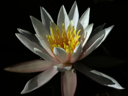
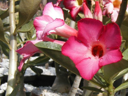
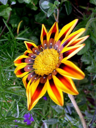
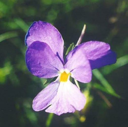
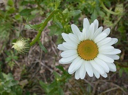

In [ ]:
#Una forma de mostrar 5 ejemplos del set
tfds.as_dataframe(datos['train'].take(5), metadatos)

# Visualizar DataSet

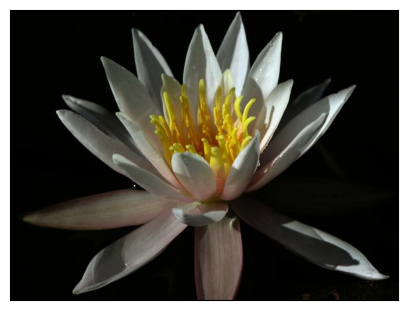

In [188]:
# visualizar el set

import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(5,5))

for i, (imagen, etiqueta) in enumerate(datos['train'].take(1)):
  plt.xticks([])
  plt.yticks([])  
  plt.imshow(imagen)

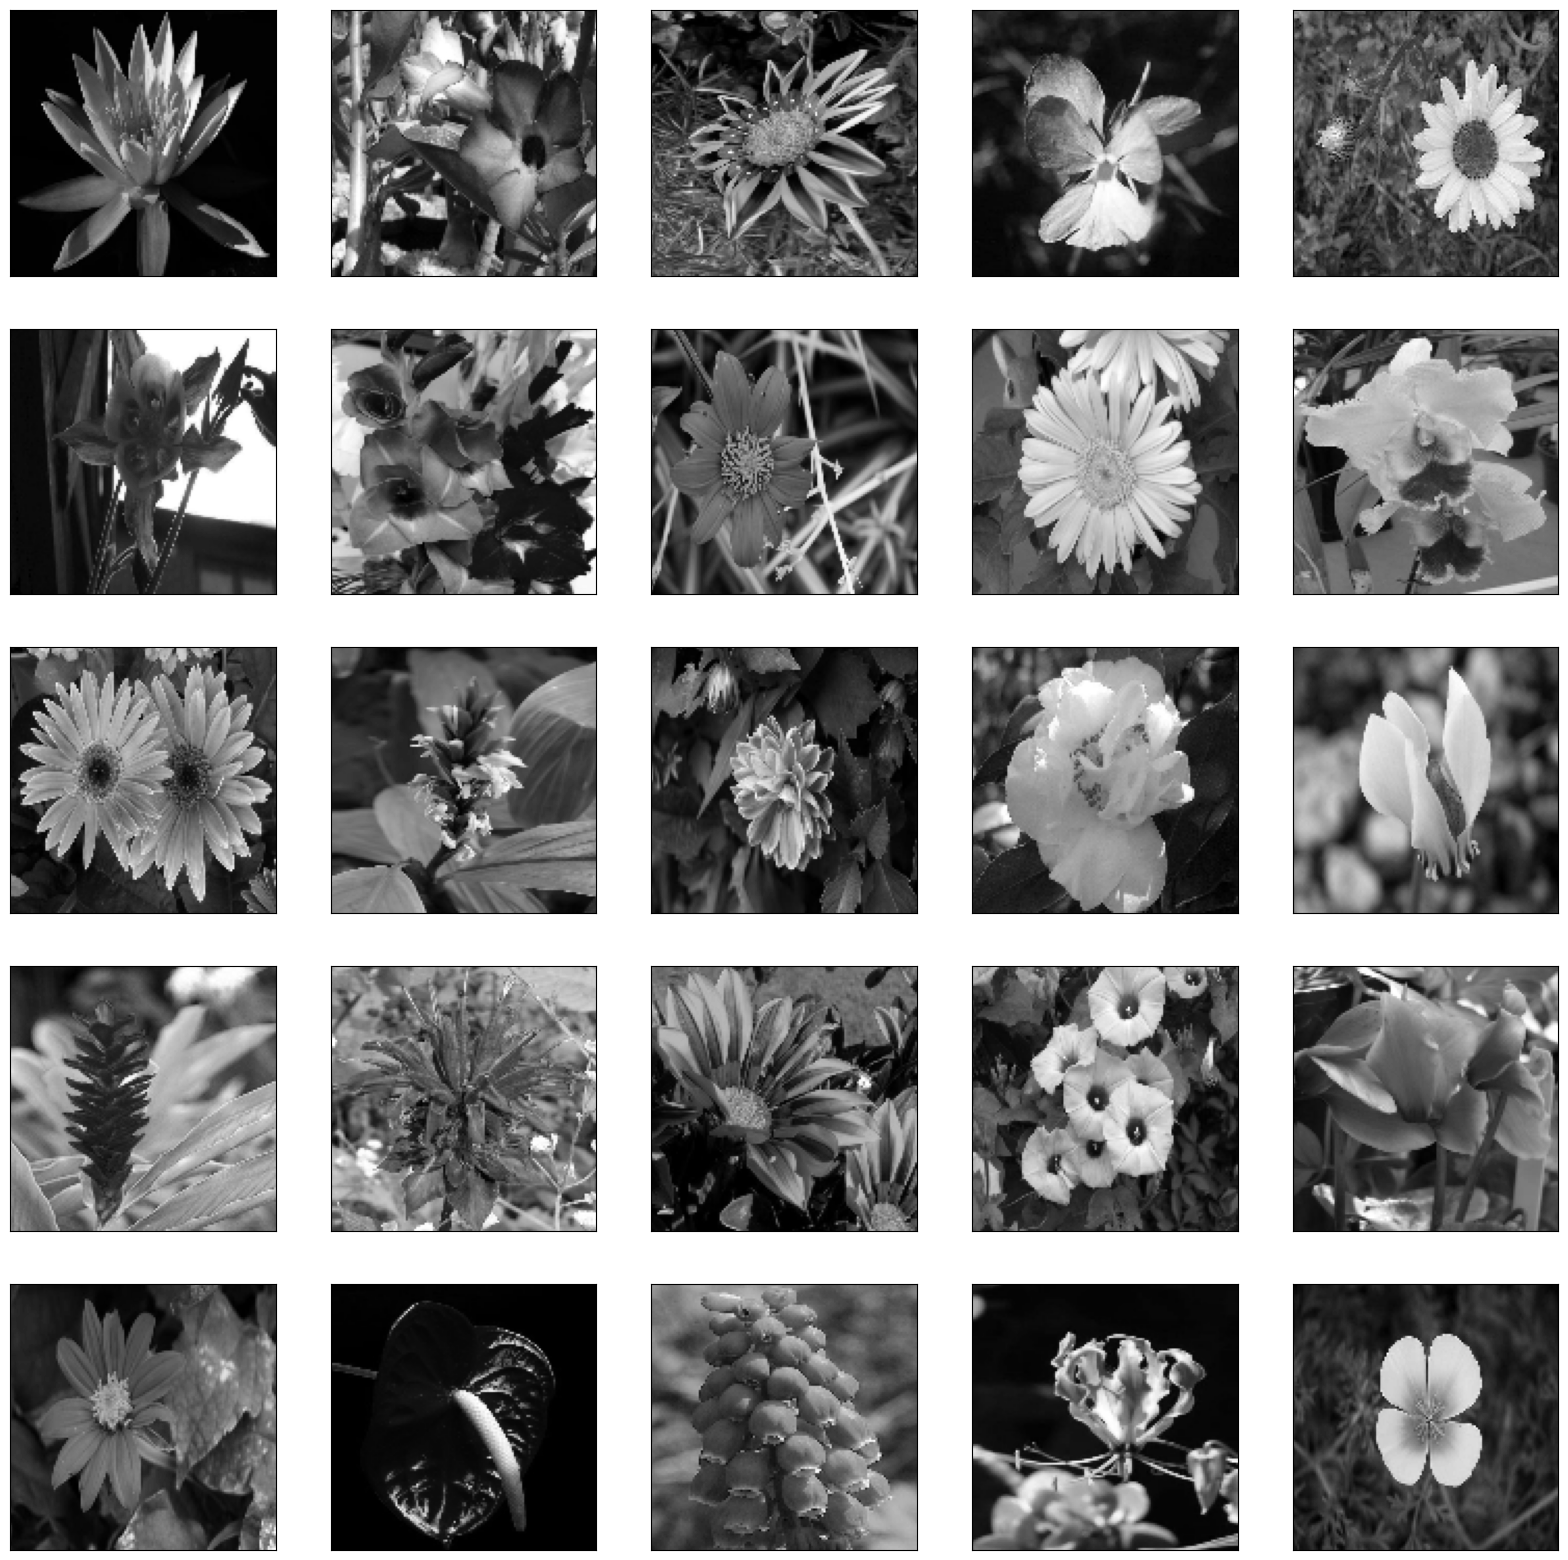

In [ ]:
#Manipular y visualizar el set
#Lo pasamos a TAMANO_IMG (128x128) y a blanco y negro (solo para visualizar)
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(20,20))

for i, (imagen, etiqueta) in enumerate(datos['train'].take(25)):
  imagen = cv2.resize(imagen.numpy(), IMG_SIZE)
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

# Construir los dataframe de Entrenamiento y Prueba

In [245]:
datos_entrenamiento, datos_pruebas, datos_validacion = datos['train'], datos['test'], datos['validation']

In [199]:
num_clases = metadatos.features['label'].num_classes
num_clases

102

In [286]:
class_names = metadatos.features['label'].names
class_names

['pink primrose',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'peruvian lily',
 'balloon flower',
 'giant white arum lily',
 'fire lily',
 'pincushion flower',
 'fritillary',
 'red ginger',
 'grape hyacinth',
 'corn poppy',
 'prince of wales feathers',
 'stemless gentian',
 'artichoke',
 'sweet william',
 'carnation',
 'garden phlox',
 'love in the mist',
 'mexican aster',
 'alpine sea holly',
 'ruby-lipped cattleya',
 'cape flower',
 'great masterwort',
 'siam tulip',
 'lenten rose',
 'barbeton daisy',
 'daffodil',
 'sword lily',
 'poinsettia',
 'bolero deep blue',
 'wallflower',
 'marigold',
 'buttercup',
 'oxeye daisy',
 'common dandelion',
 'petunia',
 'wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',

In [246]:
#Funcion de normalizacion para los datos (Pasar valor de los pixeles de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.image.resize(imagenes, IMG_SIZE)
  imagenes = tf.cast(imagenes, tf.float32) / 255 #Aqui lo pasa de 0-255 a 0-1
  #etiquetas = tf.one_hot(etiquetas, num_clases)
  return imagenes, etiquetas

In [247]:
#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
#datos_entrenamiento = datos_entrenamiento.batch(BATCH_SIZE)
datos_pruebas = datos_pruebas.map(normalizar)
#datos_pruebas = datos_pruebas.map(lambda imagen, etiqueta: (imagen, tf.one_hot(etiqueta, num_clases)))
#datos_pruebas = datos_pruebas.batch(BATCH_SIZE)
datos_validacion = datos_validacion.map(normalizar)
#datos_validacion = datos_validacion.batch(BATCH_SIZE)

In [248]:
#Cantidad de datos de entrenamiento
print(len(datos_entrenamiento))
print(len(datos_pruebas))

1020
6149


In [249]:
len(datos_validacion)

1020

#Modelo MobileNetV2

In [250]:
IMG_SHAPE = IMG_SIZE + (3,)
pretrained_model_MobileNetV2 = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights     = 'imagenet',
)

pretrained_model_MobileNetV2.trainable = False

In [ ]:
pretrained_model_MobileNetV2.summary()

#Transfer Learning
Modificamos el Modelo para ajustarlo a la salida que queremos. 102 Categorías Posibles

In [ ]:
from tensorflow.keras import regularizers

In [251]:
# Agregar las capas de clasificación adicionales al modelo
modelo_MobileNetV2 = tf.keras.Sequential([
    pretrained_model_MobileNetV2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

In [ ]:
modelo_MobileNetV2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 102)               13158     
                                                                 
Total params: 2,435,110
Trainable params: 177,126
Non-

In [253]:
# Compilar el modelo
modelo_MobileNetV2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [254]:
datos_pruebas_batch = datos_pruebas.batch(BATCH_SIZE)
datos_entrenamiento_batch = datos_entrenamiento.batch(BATCH_SIZE)

In [218]:
datos_pruebas_batch

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [255]:
#Antes de entrenar
modelo_MobileNetV2.evaluate(datos_pruebas_batch)

193/193 [==============================] - 13s 54ms/step - loss: 7.3772 - accuracy: 0.0062


[7.377175331115723, 0.006179866846650839]

#Entrenamiento


In [256]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [257]:
#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento_batch = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(BATCH_SIZE)
#datos_pruebas = datos_pruebas.batch(BATCH_SIZE)

In [258]:
initial_epochs_MobileNetV2 = 20

In [260]:
#Entrenar
%time history_MobileNetV2 = modelo_MobileNetV2.fit(datos_entrenamiento_batch, validation_data=datos_validacion.batch(batch_size),  epochs = initial_epochs_MobileNetV2, steps_per_epoch= math.ceil(num_ej_entrenamiento/batch_size))

Epoch 1/20
32/32 [==============================] - 8s 101ms/step - loss: 6.4532 - accuracy: 0.0713 - val_loss: 5.7620 - val_accuracy: 0.1255
Epoch 2/20
32/32 [==============================] - 4s 139ms/step - loss: 4.8585 - accuracy: 0.2764 - val_loss: 4.3196 - val_accuracy: 0.3735
Epoch 3/20
32/32 [==============================] - 3s 106ms/step - loss: 3.4935 - accuracy: 0.5283 - val_loss: 3.3594 - val_accuracy: 0.5324
Epoch 4/20
32/32 [==============================] - 4s 127ms/step - loss: 2.5011 - accuracy: 0.7109 - val_loss: 2.8267 - val_accuracy: 0.6167
Epoch 5/20
32/32 [==============================] - 6s 198ms/step - loss: 2.0020 - accuracy: 0.8135 - val_loss: 2.5408 - val_accuracy: 0.6441
Epoch 6/20
32/32 [==============================] - 3s 95ms/step - loss: 1.6949 - accuracy: 0.8691 - val_loss: 2.3480 - val_accuracy: 0.6716
Epoch 7/20
32/32 [==============================] - 3s 96ms/step - loss: 1.4917 - accuracy: 0.9092 - val_loss: 2.1955 - val_accuracy: 0.6814
Epoch 8/

Gráficas

In [261]:
acc =  [0.] + history_MobileNetV2.history['accuracy']
val_acc =  [0.] + history_MobileNetV2.history['val_accuracy']

loss = [ np.max(history_MobileNetV2.history['loss']) ] + history_MobileNetV2.history['loss']
val_loss = [ np.max(history_MobileNetV2.history['val_loss']) ] + history_MobileNetV2.history['val_loss']

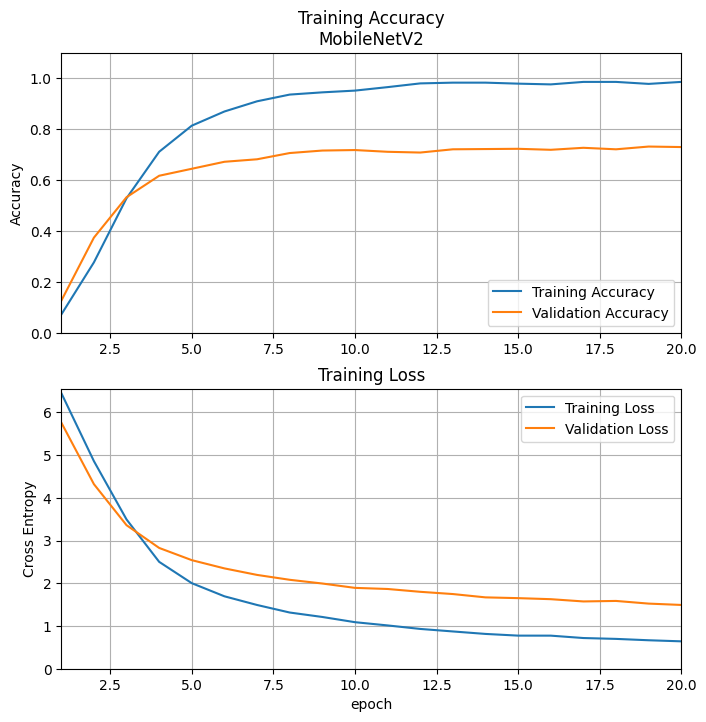

In [262]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([1,initial_epochs_MobileNetV2])
plt.ylim([0,1.1])
plt.grid(True)
plt.title('Training Accuracy\nMobileNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlim([1,initial_epochs_MobileNetV2])
max1 = np.max(loss)
max2 = np.max(val_loss)
plt.ylim([0, np.max([max1,max2])+0.1 ])
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

#Evaluar el Modelo

In [263]:
# Evaluar el modelo en el conjunto de datos de validación
datos_validacion_batch = datos_validacion.batch(BATCH_SIZE)
loss, accuracy = modelo_MobileNetV2.evaluate(datos_validacion_batch)
print("    Train Loss: {:.5f}".format(loss))
print("Train Accuracy: {:.2f}%".format(accuracy * 100))

32/32 [==============================] - 2s 72ms/step - loss: 1.4926 - accuracy: 0.7294
    Train Loss: 1.49263
Train Accuracy: 72.94%


#Conjunto de pruebas

##Cargado de imagenes

In [265]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [269]:
from tensorflow.keras.preprocessing import image

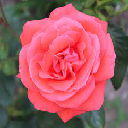

In [271]:
rosa_path = '/content/drive/MyDrive/UNISON/RedesNeuronales/Datasets/Pruebas/Rosa.jpg'
rosa = image.load_img(rosa_path, color_mode='rgb', target_size=(128, 128))
display(rosa)

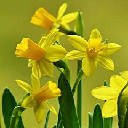

In [325]:
narcizo_path = '/content/drive/MyDrive/UNISON/RedesNeuronales/Datasets/Pruebas/Narcizo.jpg'
narcizo = image.load_img(narcizo_path, color_mode='rgb', target_size=(128, 128))
display(narcizo)

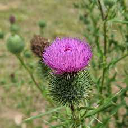

In [348]:
cardo_path = '/content/drive/MyDrive/UNISON/RedesNeuronales/Datasets/Pruebas/Cardo.jpg'
cardo = image.load_img(cardo_path, color_mode='rgb', target_size=(128, 128))
display(cardo)

##Predicciones

In [278]:
x = image.img_to_array(rosa)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
features = modelo_MobileNetV2.predict(x)

1/1 [==============================] - 1s 1s/step


In [288]:
top_prediction = np.argmax(features, axis=1)[0]

In [289]:
prediccion = class_names[top_prediction]

In [291]:
print(f'La flor predecida es: {prediccion}')

La flor predecida es: rose


In [332]:
y = image.img_to_array(narcizo)
y = np.expand_dims(y, axis=0)
y = preprocess_input(y)
features2 = modelo_MobileNetV2.predict(y)

1/1 [==============================] - 0s 24ms/step


In [338]:
top_prediction2 = np.argmax(features2, axis=1)[0]

In [339]:
prediccion2 = class_names[top_prediction2]

In [340]:
print(f'La flor predecida es: {prediccion2}')

La flor predecida es: frangipani


In [349]:
z = image.img_to_array(cardo)
z = np.expand_dims(z, axis=0)
z = preprocess_input(z)
features3 = modelo_MobileNetV2.predict(z)

1/1 [==============================] - 0s 24ms/step


In [350]:
top_prediction3 = np.argmax(features3, axis=1)[0]

In [351]:
prediccion3 = class_names[top_prediction3]

In [352]:
print(f'La flor predecida es: {prediccion3}')

La flor predecida es: spear thistle


#Modelo InceptionV3 (prueba de modelo)

In [ ]:
# Cargar el modelo pre-entrenado InceptionV3 sin la capa fully-connected (top)
pretrained_model_inceptionv3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [ ]:
# Congelar las capas del modelo pre-entrenado
for layer in pretrained_model_inceptionv3.layers:
    layer.trainable = False

In [ ]:
modelo_inceptionv3 = tf.keras.Sequential([
    pretrained_model_MobileNetV2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(num_clases, activation='softmax')
])

In [ ]:
modelo_inceptionv3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_24 (Dense)            (None, 102)               104550    
                                                                 
Total params: 3,674,278
Trainable params: 1,416,294
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Compilar el modelo
modelo_inceptionv3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics   = ['accuracy']
)

In [ ]:
#Entrenar
%time history_inceptionv3 = modelo_inceptionv3.fit(datos_entrenamiento, validation_data=datos_validacion.batch(batch_size),  epochs = 30, steps_per_epoch= math.ceil(num_ej_entrenamiento/batch_size), validation_steps=math.ceil(num_ej_entrenamiento/ batch_size))

Epoch 1/30
32/32 [==============================] - 12s 245ms/step - loss: 3.2556 - accuracy: 0.3535 - val_loss: 2.0107 - val_accuracy: 0.5235
Epoch 2/30
32/32 [==============================] - 3s 103ms/step - loss: 0.9949 - accuracy: 0.7715 - val_loss: 1.3620 - val_accuracy: 0.6490
Epoch 3/30
32/32 [==============================] - 4s 131ms/step - loss: 0.2560 - accuracy: 0.9404 - val_loss: 1.2347 - val_accuracy: 0.6765
Epoch 4/30
32/32 [==============================] - 5s 167ms/step - loss: 0.0714 - accuracy: 0.9932 - val_loss: 1.0638 - val_accuracy: 0.7039
Epoch 5/30
32/32 [==============================] - 6s 198ms/step - loss: 0.0304 - accuracy: 0.9961 - val_loss: 0.9949 - val_accuracy: 0.7343
Epoch 6/30
32/32 [==============================] - 3s 106ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.9423 - val_accuracy: 0.7451
Epoch 7/30
32/32 [==============================] - 6s 199ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.9400 - val_accuracy: 0.7451
Epoch

Gráficas

In [ ]:
acc =  [0.] + history_inceptionv3.history['accuracy']
val_acc =  [0.] + history_inceptionv3.history['val_accuracy']

loss = [ np.max(history_inceptionv3.history['loss']) ] + history_inceptionv3.history['loss']
val_loss = [ np.max(history_inceptionv3.history['val_loss']) ] + history_inceptionv3.history['val_loss']

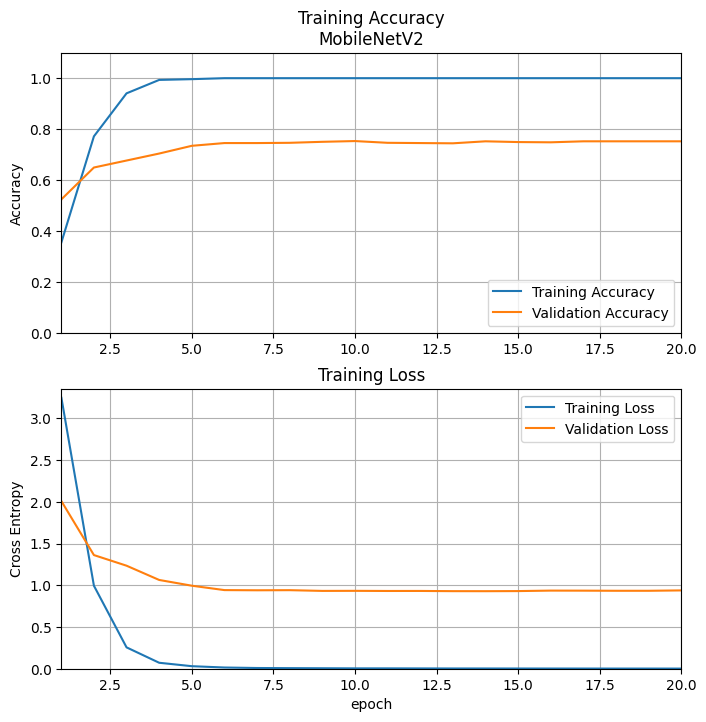

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([1,initial_epochs_MobileNetV2])
plt.ylim([0,1.1])
plt.grid(True)
plt.title('Training Accuracy\nMobileNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlim([1,initial_epochs_MobileNetV2])
max1 = np.max(loss)
max2 = np.max(val_loss)
plt.ylim([0, np.max([max1,max2])+0.1 ])
plt.grid(True)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluar el modelo en el conjunto de datos de validación
loss, accuracy = modelo_inceptionv3.evaluate(datos_pruebas)
print("    Train Loss: {:.5f}".format(loss))
print("Train Accuracy: {:.2f}%".format(accuracy * 100))

193/193 [==============================] - 11s 55ms/step - loss: 1.0388 - accuracy: 0.7443
    Train Loss: 1.03876
Train Accuracy: 74.43%


#Guardar el Modelo para usarlo

In [ ]:
#Modelo MobileNetV2
modelo_MobileNetV2.save('clasificador_flores_mbnetv2.h5')

In [ ]:
modelo_inceptionv3.save('clasificador_flores_inception3.h5')

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir carpeta_salida

In [ ]:
!tensorflowjs_converter --input_format keras clasificador_flores_mbnetv2.h5 carpeta_salida

2023-05-20 23:08:17.710224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#!tensorflowjs_converter --input_format keras --output_format=tfjs_graph_model clasificador_flores_inception3.h5 carpeta_salida

2023-05-20 23:06:34.784457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-20 23:06:37.896876: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
